In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import emd
from scipy import signal
from itertools import cycle


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Load data

In [2]:
paths = ["BSRN-PAY.nc", "BSRN-BAR.nc", "BSRN-BOU.nc", "BSRN-TAT.nc", "BSRN-CAR.nc"]
times_begin = [
    np.datetime64("1998-01-01"),
    np.datetime64("2003-01-01"),
    np.datetime64("1999-01-01"),
    np.datetime64("1998-01-01"),
    np.datetime64("1998-01-01")
]
times_end = [
    np.datetime64("2011-01-01"),
    np.datetime64("2017-01-01"),
    np.datetime64("2012-01-02"),
    np.datetime64("2023-01-01"),
    np.datetime64("2010-01-01")
]


In [3]:
# Load the data
i_path = 0 # select 0, 1, 2, 3 to load the data from the corresponding station
ds = xr.open_dataset(paths[i_path])
ds = ds.sel(time=slice(times_begin[i_path], times_end[i_path]))


# Plot data

In [4]:
PLOTTED_PERIODS = [2, 4, 8, 16, 32, 64, 128, 256, 512]

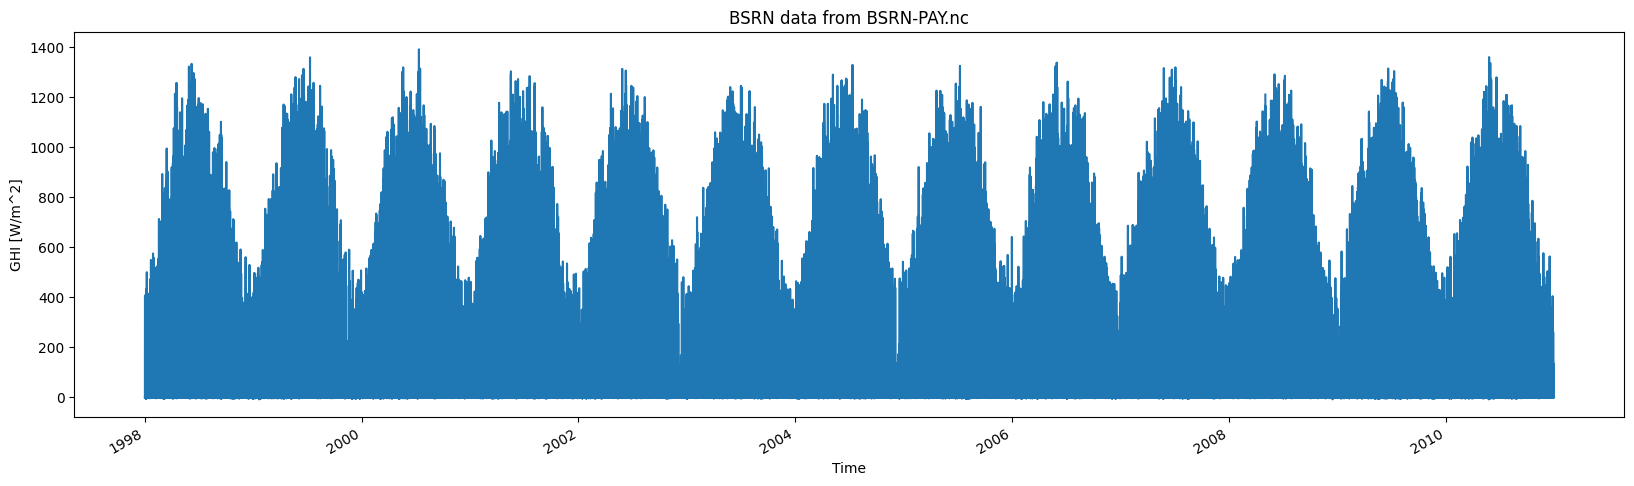

Start: 1998-01-12T12:30:00.000000000
End: 1998-01-12T12:31:00.000000000
Start: 2010-12-08T21:30:00.000000000
End: 2010-12-09T08:15:00.000000000
Longest consecutive missing data: 81 hours
Longest consecutive missing data: 3 days
Start: 2001-12-07T00:00:00.000000000
End: 2001-12-10T09:24:00.000000000


In [5]:
fig, ax = plt.subplots()
# Change figure size
fig.set_size_inches(20, 5)
ds["GHI"].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.set_title("BSRN data from " + paths[i_path])
plt.show()

# Compute the longest consecutive missing data
missing_data = ds["GHI"].isnull()
missing_data = missing_data.astype(int).diff(dim="time")
# Calculate length of consecutive missing data
missing_data_start = missing_data.where(missing_data == 1, drop=True)
missing_data_end = missing_data.where(missing_data == -1, drop=True)
# Print the start and end first timesteps
print("Start: " + str(missing_data_start["time"].values[0]))
print("End: " + str(missing_data_end["time"].values[0]))
# Print the start and end last timesteps
print("Start: " + str(missing_data_start["time"].values[-1]))
print("End: " + str(missing_data_end["time"].values[-1]))
missing_data = missing_data_end["time"].values - missing_data_start["time"].values
# Calculate the longest consecutive missing data
missing_data_hours = missing_data.max().astype("timedelta64[h]").astype(int)
missing_data_days = missing_data.max().astype("timedelta64[D]").astype(int)

index_longest = missing_data.argmax()

# Print the longest consecutive missing data
print("Longest consecutive missing data: " + str(missing_data_hours) + " hours")
print("Longest consecutive missing data: " + str(missing_data_days) + " days")
print("Start: " + str(missing_data_start["time"].values[index_longest]))
print("End: " + str(missing_data_end["time"].values[index_longest]))


# Process data

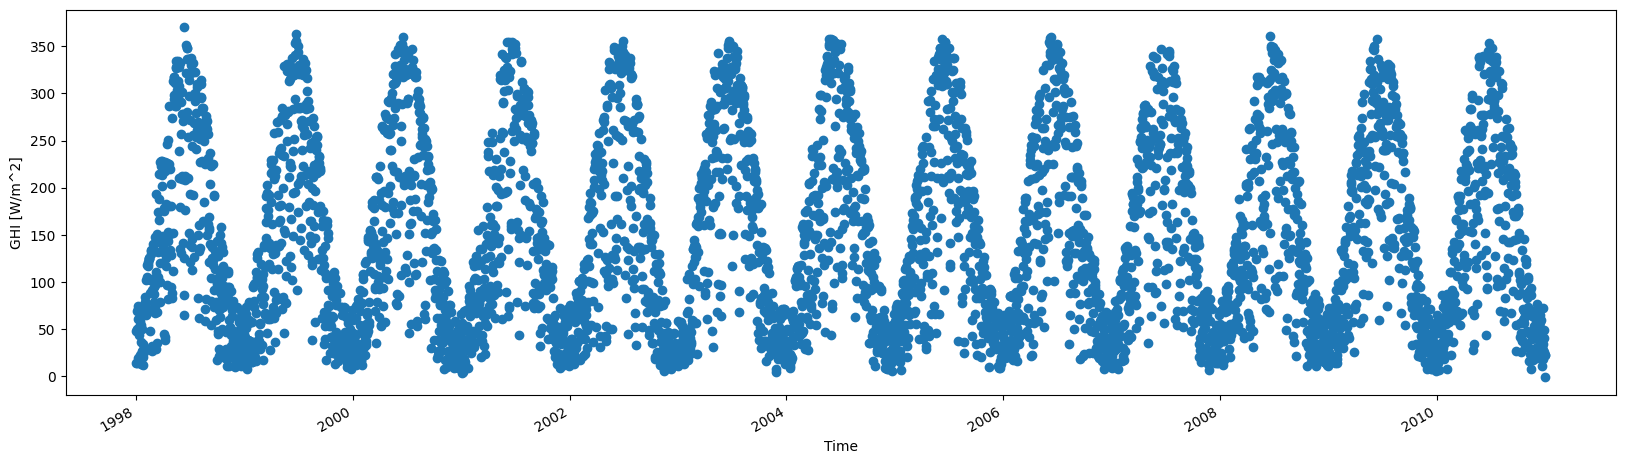

In [6]:
# Calculate the dataframe resampled
ds_resampled = ds["GHI"].resample(time="24H").reduce(
    lambda x, axis: np.nanmean(x) if np.isnan(x).sum() < 0.2 * len(x) else np.nan
)
# Interpolate the missing values
ds_resampled = ds_resampled.interpolate_na(dim="time", method="linear")

# # Take the log of the data 
# ds_resampled = np.log(ds_resampled)

# Plot the data
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ds_resampled.plot(ax=ax, marker="o", linestyle="None")
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
# ax.set_title("BSRN data from " + paths[i_path])
ax.set_title("")
plt.show()

# Perform calculation

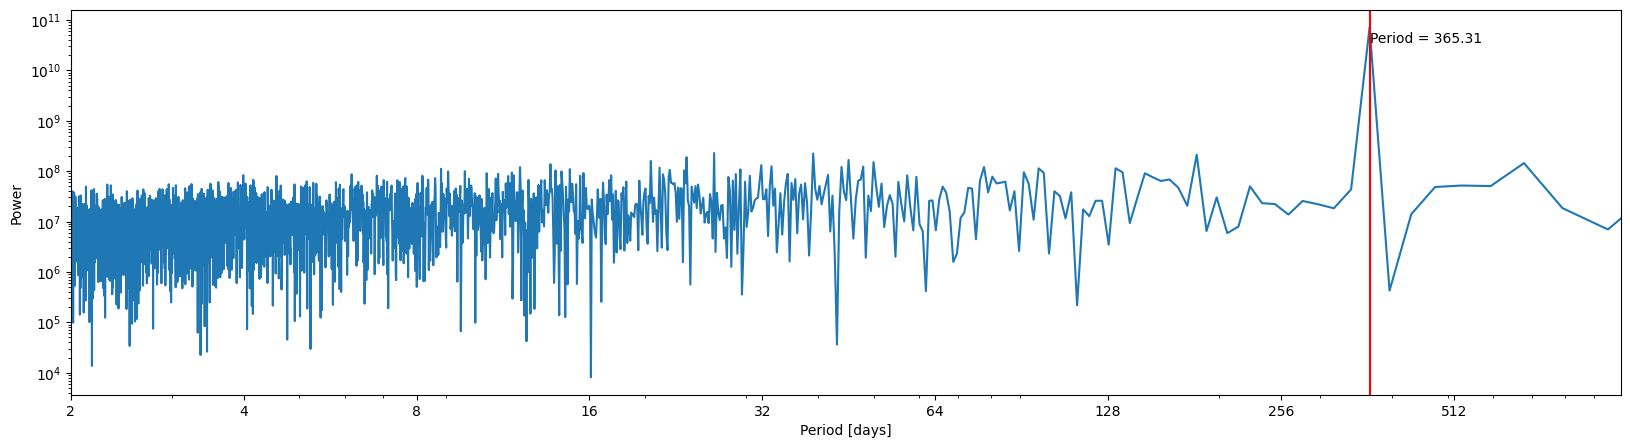

In [19]:
# Përform data analysis diagnostics
df_resampled = ds_resampled.to_dataframe()[["GHI"]]

# 1. FFT
# Calculate the FFT
fft = np.fft.fft(df_resampled["GHI"])
fft = fft[1 : len(fft) // 2]
# Calculate the power spectrum
power_spectrum = np.abs(fft) ** 2
# Calculate the frequencies
sample_freq = np.fft.fftfreq(len(df_resampled["GHI"]), d=1)
sample_freq = sample_freq[1 : len(sample_freq) // 2]
# Plot the power spectrum as a function of the period
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(1 / sample_freq, power_spectrum)
# Plot the highest peak in the power spectrum as a vertical line
max_period = 1 / sample_freq[np.argmax(power_spectrum)]
ax.axvline(max_period, color="red")
# Add text to this line
ax.text(
    max_period,
    0.5 * np.max(power_spectrum),
    "Period = " + str(np.round(max_period, 2))
)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_xlim(2, 1000)
plt.show()


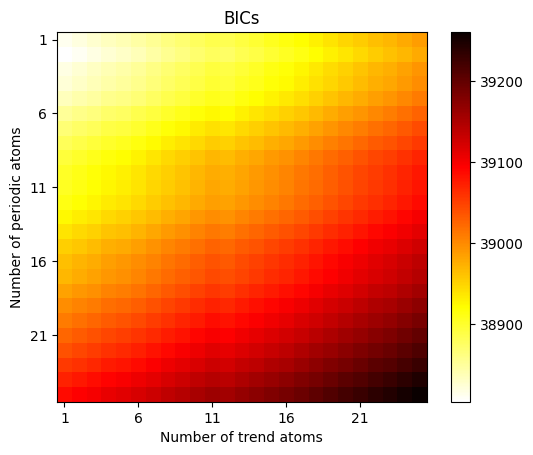

Preferred number of trend atoms: 1
Preferred number of periodic atoms: 2


In [8]:
# Extract trend (mean) and seasonality (periodic component)
def generate_trend_atoms(k, length):
    """Generate trend atoms of given length."""
    atoms = np.zeros((k, length))
    for i in range(k):
        atoms[i, :] = np.linspace(0, 1, length) ** i
    return atoms

def generate_periodic_atoms(periods, length):
    """Generate periodic atoms of given periods and length."""
    atoms = np.zeros((2 * len(periods), length))
    for i, period in enumerate(periods):
        atoms[i, :] = np.sin(np.arange(length) * 2 * np.pi / period)
        atoms[i + len(periods), :] = np.cos(np.arange(length) * 2 * np.pi / period)
    return atoms

# extract trend (mean) and seasonality (periodic component) using least squares
BICs = np.zeros((25, 25))
for i in range(1, 26):
    for j in range(1, 26):
        nb_periods = i
        periods = [max_period / p for p in np.arange(1, nb_periods + 1)]
        periodic_atoms = generate_periodic_atoms(periods, len(df_resampled["GHI"]))
        nb_trend_atoms = j
        trend_atoms = generate_trend_atoms(nb_trend_atoms, len(df_resampled["GHI"]))
        atoms = np.concatenate((periodic_atoms, trend_atoms), axis=0)

        # Calculate the least squares solution
        solution = np.linalg.lstsq(atoms.T, df_resampled["GHI"], rcond=None)[0]

        # Calculate the residuals
        residuals = df_resampled["GHI"] - np.dot(atoms.T, solution)

        # Calculate the likelihood
        likelihood = -0.5 * len(residuals) * np.log(np.sum(residuals**2 / len(residuals)))

        # Calculate the number of parameters (k) in your model
        k = len(solution)

        # Calculate BIC
        n = len(df_resampled["GHI"])
        bic = -2 * likelihood + k * np.log(n)
        BICs[i - 1, j - 1] = bic

# Plot the BICs
plt.imshow(BICs, cmap="hot_r")
plt.colorbar()
plt.xlabel("Number of trend atoms")
plt.ylabel("Number of periodic atoms")
plt.xticks(np.arange(0, 25, 5), np.arange(1, 26, 5))
plt.yticks(np.arange(0, 25, 5), np.arange(1, 26, 5))
plt.title("BICs")
plt.show()

argmin_BICs = np.argmin(BICs)
nb_periods, nb_trend_atoms = np.unravel_index(argmin_BICs, BICs.shape)
nb_periods += 1
nb_trend_atoms += 1

print("Preferred number of trend atoms: " + str(nb_trend_atoms))
print("Preferred number of periodic atoms: " + str(nb_periods))

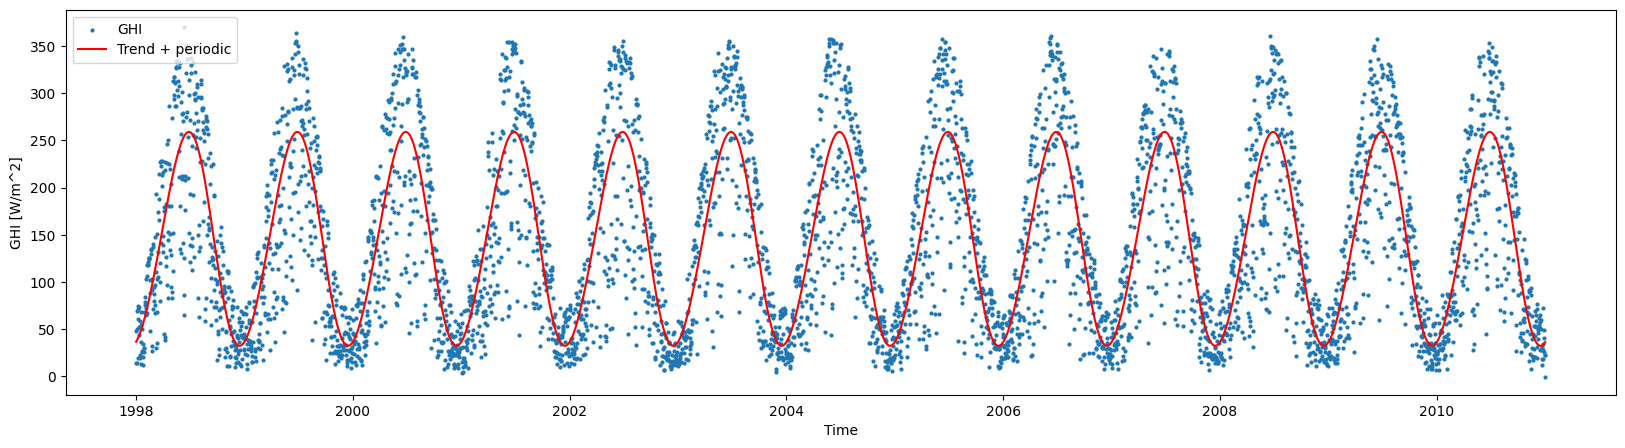

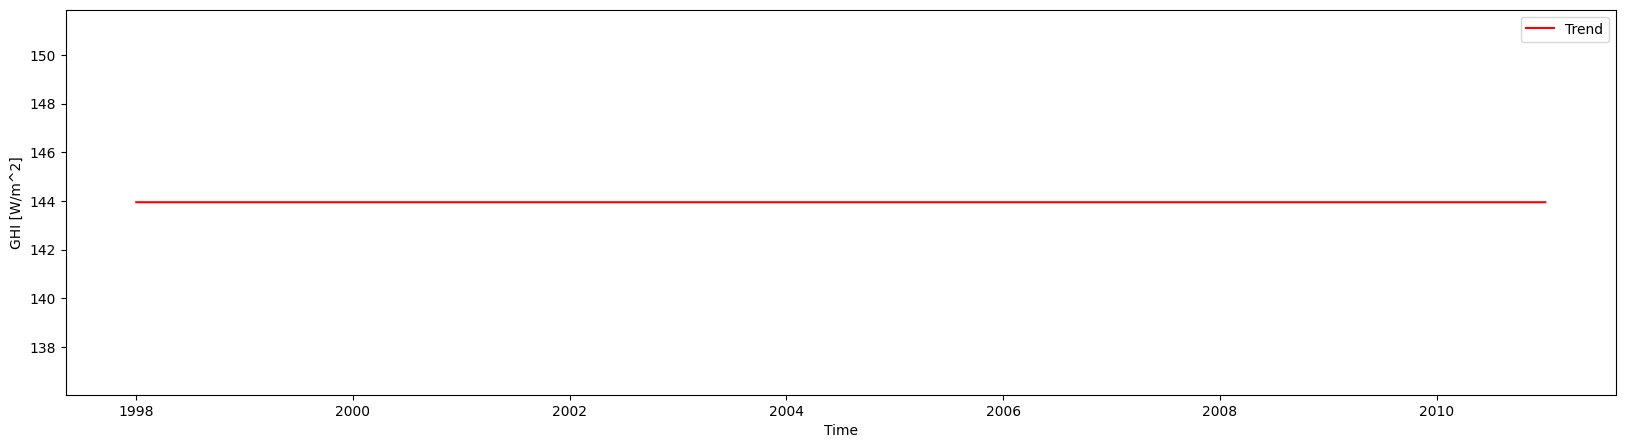

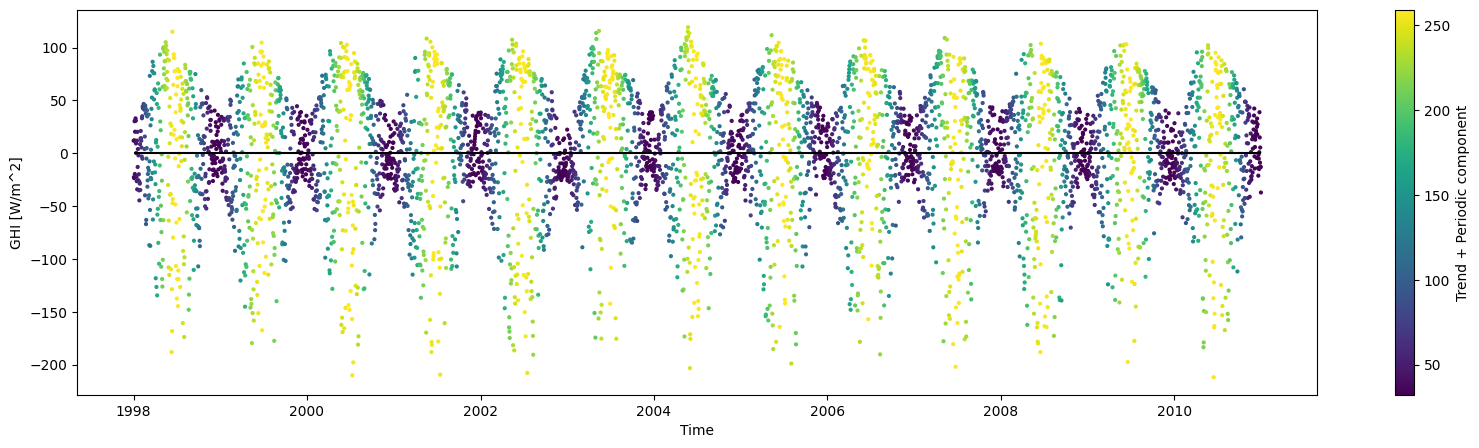

In [9]:
periods = [max_period / p for p in np.arange(1, nb_periods + 1)]
periodic_atoms = generate_periodic_atoms(periods, len(df_resampled["GHI"]))
trend_atoms = generate_trend_atoms(nb_trend_atoms, len(df_resampled["GHI"]))
atoms = np.concatenate((periodic_atoms, trend_atoms), axis=0)

# Calculate the least squares solution
solution = np.linalg.lstsq(atoms.T, df_resampled["GHI"], rcond=None)[0]

# Plot the trend and periodic components
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.scatter(df_resampled.index, df_resampled["GHI"], label="GHI", s=4)
ax.plot(df_resampled.index, np.dot(atoms.T, solution), label="Trend + periodic", color="red")
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.legend()
plt.show()

# Plot the trend
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(df_resampled.index, np.dot(trend_atoms.T, solution[nb_periods * 2:]), label="Trend", color="red")
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(20, 5))
plt.scatter(df_resampled.index, df_resampled["GHI"] - np.dot(atoms.T, solution), c=np.dot(atoms.T, solution), s=4)
plt.hlines(0, df_resampled.index[0], df_resampled.index[-1], color="black")
plt.colorbar(label="Trend + Periodic component")
plt.xlabel("Time")
plt.ylabel("GHI [W/m^2]")
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


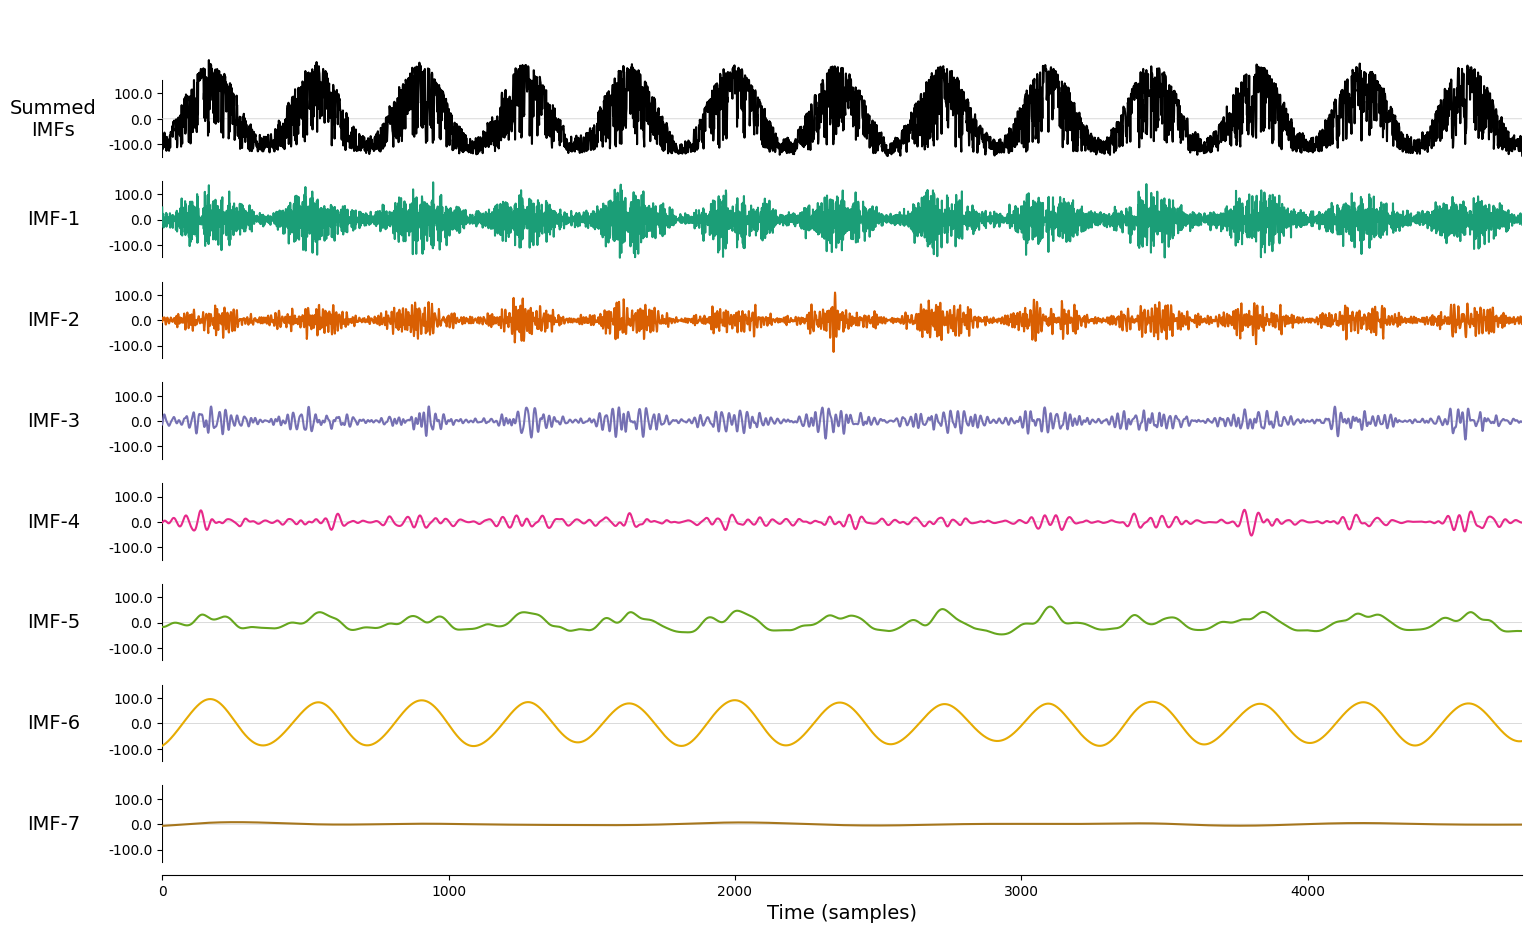

In [10]:
# Calculate the EMD
imf = emd.sift.ensemble_sift(ds_resampled.values, max_imfs=7, nensembles=1024, nprocesses=32, ensemble_noise=1)
emd.plotting.plot_imfs(imf)

IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')

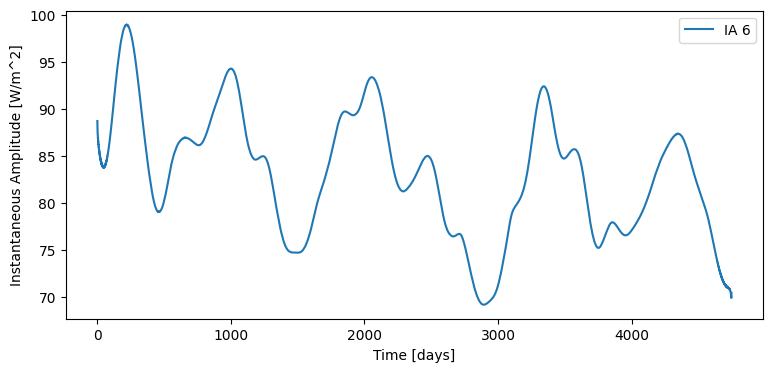

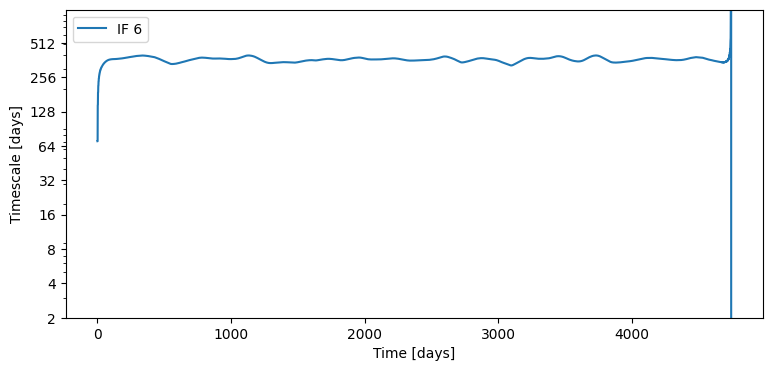

In [11]:
# Plot IA k+1 and IF k+1
k = 5
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(IA[:, k], label="IA 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Instantaneous Amplitude [W/m^2]")
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(1 / IF[:, k], label="IF 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Timescale [days]")
ax.set_yscale("log")
ax.set_yticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
ax.set_ylim(2, 1000)
ax.legend()
plt.show()


/Users/paulbonin/opt/anaconda3/envs/TS/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 4749, using nperseg = 4749
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_36200/1255942390.py:10: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_36200/1255942390.py:14: RuntimeWarning: divide by zero encountered in divide
  T = 1/f[::-1]


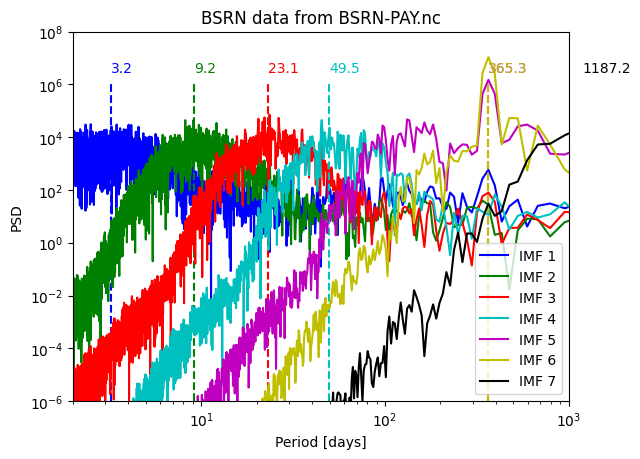

In [12]:
# Compute PSDs of the IMFs
f, Pxx = signal.welch(imf.T, fs=1, nperseg=100000)

COLORS = cycle(["b", "g", "r", "c", "m", "y", "k"])

# Plot the PSDs (x axis is period in days)
fig, ax = plt.subplots()
for i in range(imf.shape[1]):
    color = next(COLORS)
    ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
    # Plot the median of the PSD for each IMF (vline)
    cumsum_T = np.cumsum(Pxx[i, ::-1])
    cumsum_T /= cumsum_T[-1]
    T = 1/f[::-1]
    T = T[cumsum_T > 0.5][0]
    ax.vlines(T, 1e-6, 1e6, color=color, linestyle="--")
    # add text
    ax.text(T, 3e6, "%.1f" % T, color=color)
ax.legend()
ax.set_xlabel("Period [days]")
ax.set_ylabel("PSD")
ax.set_title("BSRN data from " + paths[i_path])
ax.set_xscale("log")
ax.set_yscale("log")
# limit the y axis
ax.set_ylim(1e-6, 1e8)
ax.set_xlim(2, 1000)
plt.show()

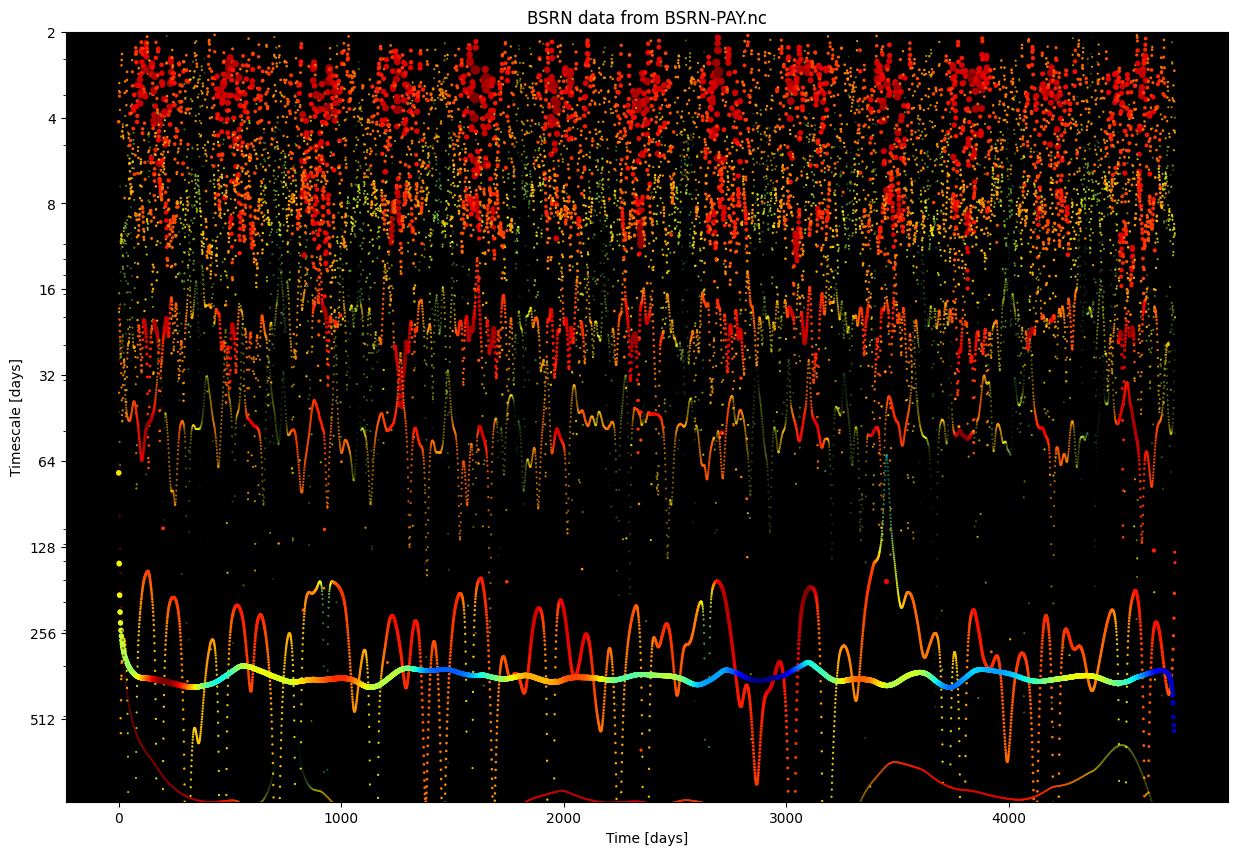

In [13]:
plt.figure(figsize=(15, 10))
# Set background color
plt.rcParams['axes.facecolor'] = "k"
for i in range(imf.shape[1]):
    plt.scatter(np.arange(len(imf)), IF[:, i], c=np.log(IA[:, i]), cmap="jet", s=0.001*IA[:, i]**2, label="IMF %d" % (i +1))
plt.xlabel("Time [days]")
plt.ylabel("Timescale [days]")
plt.title("BSRN data from " + paths[i_path])
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.show()

plt.rcParams['axes.facecolor'] = "w"


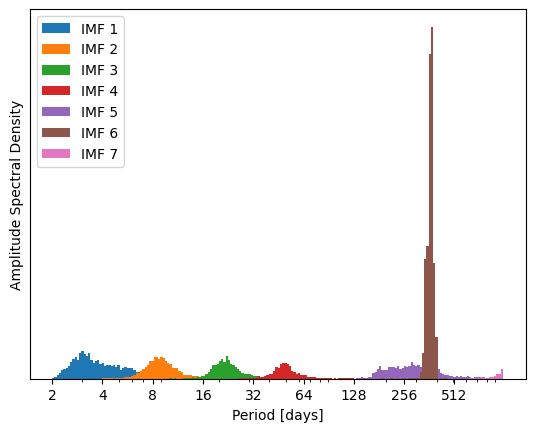

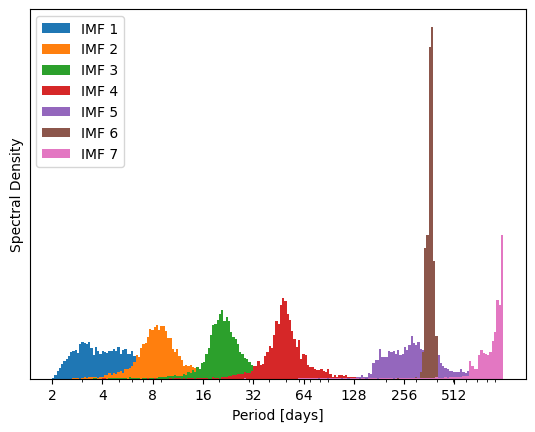

In [14]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')

f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
f, hht_0a = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)

# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Amplitude Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()


# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht_0a[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()

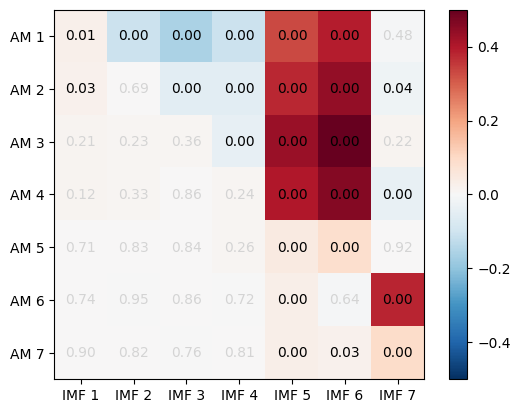

In [15]:
# Compute Kendall's taucorrelation matrix between IA and IMFs
from scipy.stats import kendalltau

taus = np.zeros((imf.shape[1], imf.shape[1]))
ps = np.zeros((imf.shape[1], imf.shape[1]))
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        tau, p = kendalltau(IA[:, i], imf[:, j])
        taus[i, j] = tau
        ps[i, j] = p

# Plot the correlation matrix as a heatmap (p values are written in the cells)
plt.imshow(taus, cmap="RdBu_r", vmin=-0.5, vmax=0.5)
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        plt.text(j, i, "%.2f" % ps[i, j], ha="center", va="center", color="#000000" if ps[i, j] < 0.05 else "#d4d4d4")
plt.xticks(np.arange(imf.shape[1]), ["IMF %d" % (i + 1) for i in range(imf.shape[1])])
plt.yticks(np.arange(imf.shape[1]), ["AM %d" % (i + 1) for i in range(imf.shape[1])])
plt.colorbar()
plt.show()

In [16]:
def resample_float_rate_linear_interp(x, y, rate):
    """Resample a float rate time series using linear interpolation."""
    # Create a new time series with the desired rate
    new_x = np.arange(x[0], x[-1], rate)
    # Interpolate the original time series at the new time series
    new_y = np.interp(new_x, x, y)
    return new_x, new_y

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW

resample_rates = np.arange(24, 48, 2)
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')
SWMFs = np.zeros((len(resample_rates), 7))
SWUQs = np.zeros((len(resample_rates), 7))
SWLQs = np.zeros((len(resample_rates), 7))
for i_rr, rr in enumerate(resample_rates):
    freq_ratio = 24 / rr
    # ds_resampled_2 = ds["GHI"].resample(time="{}H".format(rr)).reduce(
    #     lambda x, axis: np.nanmean(x) if np.isnan(x).sum() < 0.2 * len(x) else np.nan
    # )
    # ds_resampled_2 = ds_resampled.interpolate_na(dim="time", method="linear").values
    ds_resampled_2 = resample_float_rate_linear_interp(
        np.arange(len(ds_resampled)),
        ds_resampled.values,
        rr / 24
    )[1]
    print(len(ds_resampled_2))
    imf = emd.sift.ensemble_sift(ds_resampled_2, max_imfs=7, nensembles=1024, nprocesses=32, ensemble_noise=4)
    IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
    ws = [DescrStatsW(freq_ratio * f, weights=hht[:, i]) for i in range(hht.shape[1])]
    SWMFs[i_rr, :] = np.array([w.mean for w in ws])
    SWUQs[i_rr, :] = np.array([w.quantile([0.75], return_pandas=False)[0] for w in ws])
    SWLQs[i_rr, :] = np.array([w.quantile([0.25], return_pandas=False)[0] for w in ws])

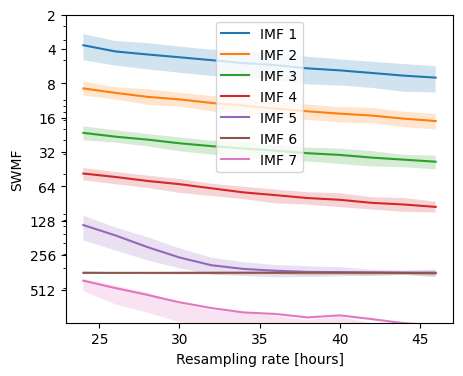

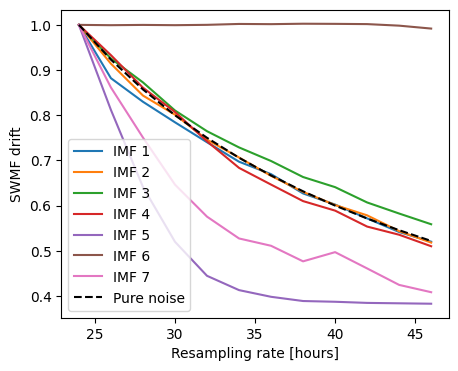

In [18]:
# Plot the SWMFs
plt.figure(figsize=(5, 4))
for i in range(imf.shape[1]):
    plt.plot(resample_rates, SWMFs[:, i], label="IMF %d" % (i +1))
    # Plot upper and lower quartiles
    plt.fill_between(resample_rates, SWUQs[:, i], SWLQs[:, i], alpha=0.2)

# Plot the behaviour of the SWMF for a pure noise signal
plt.xlabel("Resampling rate [hours]")
plt.ylabel("SWMF")
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.legend()
plt.show()

# Plot the SWMFs
plt.figure(figsize=(5, 4))
for i in range(imf.shape[1]):
    plt.plot(resample_rates, SWMFs[:, i] / SWMFs[0, i], label="IMF %d" % (i +1))
# Plot the behaviour of the SWMF for a pure noise signal
plt.plot(resample_rates, 24 / resample_rates, color="black", linestyle="--", label="Pure noise")
plt.xlabel("Resampling rate [hours]")
plt.ylabel("SWMF drift")
plt.legend()
plt.show()